In [8]:
import os
import json

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# obtain skeletons + label

DSET_PATH = "D:\ComputerVision\CV_gesture_detection"
TRAIN_PATH = os.path.join(DSET_PATH, "train_skeletons")
TEST_PATH = os.path.join(DSET_PATH, "test_skeletons")

def load_skel_data(path):
    skeletons = torch.load(os.path.join(path, "skeletons_tensor.pt"))  
    with open(os.path.join(path, "skeleton_annots.json"), "r") as f:
        metadata = json.load(f)
    return skeletons, metadata

train_skels, train_metadata = load_skel_data(TRAIN_PATH)
test_skels, test_metadata = load_skel_data(TEST_PATH)

# minus one to make 0-indexed
train_labels = torch.tensor(
    [sample["label_id"] - 1 for sample in train_metadata["samples"]],
    dtype=torch.long,
)
test_labels = torch.tensor(
    [sample["label_id"] - 1 for sample in test_metadata["samples"]],
    dtype=torch.long,
)


# filter out first 100 training datapoints since they aren't labelled well
train_skels = train_skels[100:]
train_labels = train_labels[100:]

num_classes = len(torch.unique(train_labels))

# sanity check stuff
print("Labels shape:", train_labels.shape)
print("Skeletons shape:", train_skels.shape)
print("Num classes:", num_classes)

Labels shape: torch.Size([3781])
Skeletons shape: torch.Size([3781, 210, 21, 3])
Num classes: 14


C:\Users\echan\AppData\Local\Temp\ipykernel_3332\3381739156.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  skeletons = torch.load(os.path.join(path, "skeletons_tensor.p

In [ ]:
# DO NOT RUN
# split data randomly (for when I only had access to the train set)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_skels.numpy(),
    train_labels.numpy(),
    test_size=0.2,
    stratify=train_labels.numpy(),
    random_state=42
)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

In [10]:
# training stuff 
train_ds = TensorDataset(train_skels, train_labels)
test_ds = TensorDataset(train_skels, train_labels)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Train samples:", len(train_ds))
print("Test samples:", len(test_ds))

Train samples: 3781
Test samples: 3781


In [5]:
T, J, C = train_skels.shape[1:]  
input_dim = T * J * C

class BasicGLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()

        self.net = nn.Sequential(

            nn.Linear(input_dim, 420),
            nn.LayerNorm(420),
            nn.ReLU(),
            nn.Dropout(0.420),

            nn.Linear(420, 69 * 2),
            nn.LayerNorm(69 * 2),
            nn.ReLU(),
            nn.Dropout(0.69 - 0.420),

            nn.Linear(69 * 2, 67),
            nn.ReLU(),
            
            nn.Linear(67, num_classes)
   
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        return self.net(x)

device = torch.device("cuda:0")
print(device)
#print("Device name:", torch.cuda.get_device_name(0))
model = BasicGLP(input_dim, num_classes).to(device)
print(model)

cuda:0
BasicGLP(
  (net): Sequential(
    (0): Linear(in_features=13230, out_features=420, bias=True)
    (1): LayerNorm((420,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.42, inplace=False)
    (4): Linear(in_features=420, out_features=138, bias=True)
    (5): LayerNorm((138,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): Dropout(p=0.26999999999999996, inplace=False)
    (8): Linear(in_features=138, out_features=67, bias=True)
    (9): ReLU()
    (10): Linear(in_features=67, out_features=14, bias=True)
  )
)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# training loop
def run_epoch(loader, model, criterion, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    correct = 0
    total = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device, dtype=torch.float32)
        y_batch = y_batch.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        logits = model(x_batch)           # forward pass
        loss = criterion(logits, y_batch) # compute loss

        if optimizer is not None:
            loss.backward()               # backprop
            optimizer.step()              # update weights

        total_loss += loss.item() * x_batch.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc

num_epochs = 75

train_accs = []
test_accs = []
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
    test_loss, test_acc = run_epoch(test_loader, model, criterion, optimizer=None)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
        f"test_loss={test_loss:.4f}, test_acc={test_acc:.3f}"
    )

Epoch 01 | train_loss=2.3911, train_acc=0.216 | test_loss=2.2904, test_acc=0.240
Epoch 02 | train_loss=2.2540, train_acc=0.308 | test_loss=2.1624, test_acc=0.344
Epoch 03 | train_loss=2.1413, train_acc=0.345 | test_loss=2.0233, test_acc=0.362
Epoch 04 | train_loss=2.0548, train_acc=0.387 | test_loss=1.9521, test_acc=0.387
Epoch 05 | train_loss=1.9688, train_acc=0.402 | test_loss=1.8475, test_acc=0.410
Epoch 06 | train_loss=1.8714, train_acc=0.433 | test_loss=1.7714, test_acc=0.449
Epoch 07 | train_loss=1.7935, train_acc=0.453 | test_loss=1.6543, test_acc=0.507
Epoch 08 | train_loss=1.7025, train_acc=0.482 | test_loss=1.5915, test_acc=0.487
Epoch 09 | train_loss=1.6360, train_acc=0.493 | test_loss=1.4600, test_acc=0.548
Epoch 10 | train_loss=1.5639, train_acc=0.524 | test_loss=1.4359, test_acc=0.579
Epoch 11 | train_loss=1.4965, train_acc=0.527 | test_loss=1.2989, test_acc=0.588
Epoch 12 | train_loss=1.3992, train_acc=0.560 | test_loss=1.2074, test_acc=0.602
Epoch 13 | train_loss=1.3441

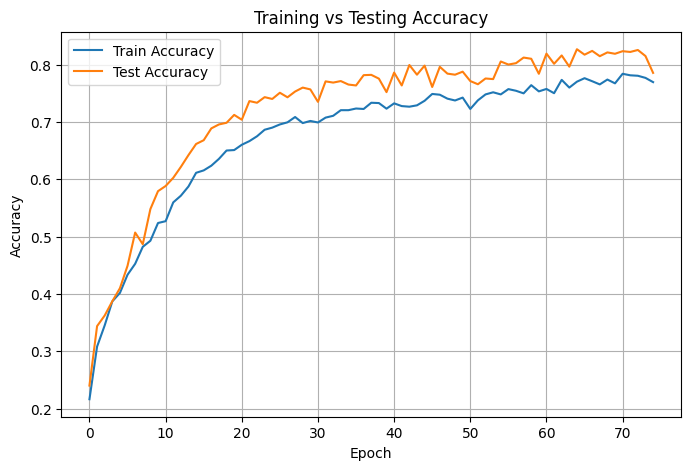

In [7]:
epochs = np.arange(num_epochs)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()